# A tutorial using the human BMMC SHARE-seq data

first load all the relevant libraries

In [3]:
%load_ext autoreload
%autoreload 2
import scprinter as scp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import os
import pickle
import torch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from scanpy.plotting.palettes import zeileis_28
from tqdm.contrib.concurrent import *
from tqdm.auto import *
import anndata
import scanpy as sc
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


define path to the relevant files, minimum files needed is just: 
- fragments
you can generate peaks using the scprinter package, but a pre-defined region would also work

If you will be using LoRA to infer single cell / pseudo-bulk level sequence features, also provide:
- grouping of the cells
- embeddings of the cells

In [4]:
work_dir = '/data/rzhang/PRINT_rev/BMMC_tutorial'
frag = f'{work_dir}/merged.fragments.tsv.gz'
peak = f'{work_dir}/regions.bed'
barcodegroups = pd.read_table(f'{work_dir}/barcodeGrouping.txt.gz')
groupinfo = pd.read_table(f'{work_dir}/groupInfo.txt')
embeddings = pd.read_csv(f'{work_dir}/cellEmbedding.tsv.gz', sep='\t')
cell_type = pd.read_csv(f'{work_dir}/celltype_info.tsv', sep='\t')

## Create scprinter & preprocessing

### Creating or load the scprinter object

scprinter object is the core object to do footprinting and train seq2print models

In [6]:
import scprinter as scp
import time
start = time.time()
if os.path.exists(f'{work_dir}/scprinter.h5ad'):
    printer = scp.load_printer(f'{work_dir}/scprinter.h5ad', scp.genome.hg38)
else:
    printer = scp.pp.import_fragments(
                        pathToFrags= frag,
                        barcodes=np.unique(barcodegroups['barcode']),
                        savename=f'{work_dir}/scprinter.h5ad',
                        genome=scp.genome.hg38,
                        min_num_fragments=0, min_tsse=0,
                        sorted_by_barcode=False, 
                        low_memory=False
                        )
print ("takes", time.time()-start)

loading test_region /data/rzhang/PRINT_rev/BMMC_tutorial/scprinter_supp/test_region.h5ad
takes 161.59124994277954


In [7]:
printer

head project
AnnData object with n_obs x n_vars = 833086 x 0 backed at '/data/rzhang/PRINT_rev/BMMC_tutorial/scprinter.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'gff_db', 'bias_bw', 'genome', 'unique_string', 'binding score', 'footprints', 'group_bigwig', 'insertion', 'bias_path', 'peak_calling', 'reference_sequences'
    obsm: 'insertion_chrX', 'insertion_chr14', 'insertion_chrY', 'fragment_paired', 'insertion_chr18', 'insertion_chr9', 'insertion_chr19', 'insertion_chr22', 'insertion_chr6', 'insertion_chr13', 'insertion_chr1', 'insertion_chr3', 'insertion_chr21', 'insertion_chr4', 'insertion_chr11', 'insertion_chr10', 'insertion_chr15', 'insertion_chr17', 'insertion_chr5', 'insertion_chr16', 'insertion_chr7', 'insertion_chr2', 'insertion_chr8', 'insertion_chr20', 'insertion_chr12'
detected 1 footprintsadata
name test_region
AnnData object with n_obs x n_vars = 135 x 1 backed at '/data/rzhang/PRINT_rev/BMMC_tutorial/scprinter_supp/test_region.h5ad'
    obs: 

take a look at the barcodegroups, groupinfo, and embeddings

In [8]:
barcodegroups

,barcode,group
0,T128.R1.124.R2.026.R3.048.P1.02,1
1,T128.R1.037.R2.155.R3.075.P1.06,1
2,T128.R1.057.R2.043.R3.017.P1.03,1
3,T128.R1.001.R2.057.R3.120.P1.02,1
4,T128.R1.041.R2.077.R3.050.P1.08,1
...,...,...
4999995,T124.R1.109.R2.097.R3.143.P1.04,1000
4999996,T128.R1.069.R2.095.R3.157.P1.03,1000
4999997,T128.R1.065.R2.068.R3.190.P1.01,1000
4999998,T128.R1.059.R2.126.R3.101.P1.02,1000


In [9]:
groupinfo

,groupID,cellType,UMAP1,UMAP2,Pseudotime,color,MyeloidProbs,ErythroidProbs,BLymphoidProbs,TLymphoidProbs
0,1,CD4,9.001021,0.096889,0.977142,#005F9F,0.00000,0.0,0.0,0.998463
1,2,CD16mono,-8.828829,5.639757,0.367753,#F26625,0.99921,0.0,0.0,0.000000
2,3,CD14mono,-9.002045,2.610761,0.373777,#F28238,0.99923,0.0,0.0,0.000000
3,4,late-Ery,-8.157805,-10.942774,0.905431,#901838,0.00000,1.0,0.0,0.000000
4,5,NK,3.967188,-6.635262,0.989003,#492264,0.00000,0.0,0.0,0.999085
...,...,...,...,...,...,...,...,...,...,...
995,996,late-Ery,-8.127533,-10.584183,0.895157,#901838,0.00000,1.0,0.0,0.000000
996,997,late-Ery,-7.567782,-10.629585,0.874019,#901838,0.00000,1.0,0.0,0.000000
997,998,NK,2.886501,-8.023002,0.996672,#492264,0.00000,0.0,0.0,0.999327
998,999,CD8,3.166318,-3.892827,0.984040,#1481C4,0.00000,0.0,0.0,0.998780


### call peaks on the fragments in a preset for training seq2PRINT model

Use all barcodes presented, and call peaks. Use the preset "seq2PRINT" to generate peaks that is appropriate to train a seq2PRINT model on.
It is recommended to do this, instead of using your predefined peak region to train seq2PRINT

In [8]:
scp.pp.call_peaks(printer=printer, 
                  frag_file=frag,
                  cell_grouping=[list(printer.obs_names)], # here we call peaks on the cells that are included in the final analyses
                  group_names=['all'], 
                  preset='seq2PRINT')

INFO  @ Sat, 27 Jul 2024 00:49:33: 
# Command line: callpeak --nomodel -t /data/rzhang/PRINT_rev/BMMC_tutorial/scprinter_supp/all_filtered_frag.tsv.gz --outdir /data/rzhang/PRINT_rev/BMMC_tutorial/scprinter_supp/macs2 -n all -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -p 0.01
# ARGUMENTS LIST:
# name = all
# format = BEDPE
# ChIP-seq file = ['/data/rzhang/PRINT_rev/BMMC_tutorial/scprinter_supp/all_filtered_frag.tsv.gz']
# control file = None
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# pvalue cutoff = 1.00e-02
# qvalue will not be calculated and reported as -1 in the final output.
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Paired-End mode is 

Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 500 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 268930 peaks unresolved 266965 peaks selected
round: 2 68 peaks unresolved 68 peaks selected
finish clearing
finish sorting
finished summary


In [9]:
# fetched the cleaned peaks, save, it will be used in the next step
cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['all_cleaned'][:])
cleaned_peaks.to_csv(f'{work_dir}/seq2print_cleaned_narrowPeak.bed', 
                     sep='\t', header=False, index=False)

cleaned_peaks

,0,1,2,3,4,5,6,7
0,chr1,816837,817837,all_peak_7,1455.05,1455.05,all,23591
1,chr1,825289,826289,all_peak_8,2.62458,2.62458,all,256539
2,chr1,827024,828024,all_peak_9,8861.23,8861.23,all,7168
3,chr1,828857,829857,all_peak_10a,34.2292,34.2292,all,133053
4,chr1,829685,830685,all_peak_10b,4.63524,4.63524,all,230125
...,...,...,...,...,...,...,...,...
267028,chrX,155611170,155612170,all_peak_141298b,191.643,191.643,all,71515
267029,chrX,155612355,155613355,all_peak_141298c,1855.33,1855.33,all,20021
267030,chrX,155632167,155633167,all_peak_141299,300.122,300.122,all,58695
267031,chrX,155641003,155642003,all_peak_141300,2.08109,2.08109,all,265737


## Training and analyses regarding seq2PRINT trained on the pseudobulk of all cells

### Generate the configuration files

Here let's train a bulk model that uses cells of all cell type , we use the default parameters for seq2PRINT. Note that you can change the cell_grouping etc to create a cell type specific model easily.

In [10]:
import json
model_configs = []
if not os.path.exists(os.path.join(work_dir, 'configs')):
    os.makedirs(os.path.join(work_dir, 'configs'))
for fold in range(5):
    model_config= scp.tl.seq_model_config(printer, 
                                     region_path=f'{work_dir}/seq2print_cleaned_narrowPeak.bed',
                                     cell_grouping=printer.obs_names,
                                     group_names='BMMC_Bulk',
                                     genome=printer.genome,
                                     fold=fold,
                                     overwrite_bigwig=False,
                                     model_name='BMMC_Bulk',
                                     additional_config={
                                        "notes": "v3",
                                        "tags": ["BMMC",
                                            "Bulk",
                                            f"fold{fold}"]},
                                     path_swap=(work_dir, ''),
                                     config_save_path=f'{work_dir}/configs/BMMC_fold{fold}.JSON')
    model_configs.append(model_config)

Loading insertion profiles
Creating bigwig for BMMC_Bulk


  0%|          | 0/24 [00:00<?, ?it/s]

bigwig for BMMC_Bulk already exists, skip
bigwig for BMMC_Bulk already exists, skip
bigwig for BMMC_Bulk already exists, skip
bigwig for BMMC_Bulk already exists, skip


### launch the training script

In [14]:
for path in ['temp','model']:
    if not os.path.exists(os.path.join(work_dir, path)):
        os.makedirs(os.path.join(work_dir, path))
        
for fold in range(5):
    scp.tl.launch_seq2print(model_config_path=f'{work_dir}/configs/BMMC_fold{fold}.JSON',
                            temp_dir='../PRINT_rev/BMMC_tutorial/temp',
                            model_dir='../PRINT_rev/BMMC_tutorial/model',
                            data_dir='../PRINT_rev/BMMC_tutorial',
                            gpus=fold,
                            wandb_project='scPrinter_seq_tutorial', # wandb helps you manage loggins
                            verbose=True, 
                            launch=False # launch=True, this command would launch the scripts directly, 
                            # otherwise, it will just display the commands, you should copy them and run them.
                           )

Please copy the following command in your terminal and run it to start the job
CUDA_VISIBLE_DEVICES=0 seq2print_train --config /data/rzhang/PRINT_rev/BMMC_tutorial/configs/BMMC_fold0.JSON --temp_dir ../PRINT_rev/BMMC_tutorial/temp --model_dir ../PRINT_rev/BMMC_tutorial/model --data_dir ../PRINT_rev/BMMC_tutorial --project scPrinter_seq_tutorial --enable_wandb
Please copy the following command in your terminal and run it to start the job
CUDA_VISIBLE_DEVICES=1 seq2print_train --config /data/rzhang/PRINT_rev/BMMC_tutorial/configs/BMMC_fold1.JSON --temp_dir ../PRINT_rev/BMMC_tutorial/temp --model_dir ../PRINT_rev/BMMC_tutorial/model --data_dir ../PRINT_rev/BMMC_tutorial --project scPrinter_seq_tutorial --enable_wandb
Please copy the following command in your terminal and run it to start the job
CUDA_VISIBLE_DEVICES=2 seq2print_train --config /data/rzhang/PRINT_rev/BMMC_tutorial/configs/BMMC_fold2.JSON --temp_dir ../PRINT_rev/BMMC_tutorial/temp --model_dir ../PRINT_rev/BMMC_tutorial/model 

### generate sequence attribution score

after locate the trained models, we can generate the sequence attribution scores for the count and footprint output of the seq2print model, and used it for downstream tasks

In [19]:
pretrain_models = ['BMMC_Bulk_fold0-apricot-dew-102.pt',
                  'BMMC_Bulk_fold1-misunderstood-resonance-101.pt',
                  'BMMC_Bulk_fold2-sweet-tree-105.pt',
                  'BMMC_Bulk_fold3-blooming-deluge-103.pt',
                  'BMMC_Bulk_fold4-worthy-pond-104.pt']
model_path = [os.path.join(work_dir, "model", m) for m in pretrain_models]

In [20]:
# This will generate the sequence attribution scores for the footprint, you can input multiple models, it will iterate over them
scp.tl.seq_attr_seq2print(
    genome=printer.genome,
    region_path=peak,
    model_type='seq2print',
    model_path=model_path,
    gpus=[0,1,2,3,4,5,6,7],
    preset='footprint',
    overwrite=False,
    verbose=True,
    launch=False)

Using preset, the following parameters would be overwritten
using wrapper: just_sum
using nth_output: 0-30
using decay: 0.85
Please copy the following command in your terminal and run it to start the job
seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Bulk_fold0-apricot-dew-102.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/regions.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key deepshap --model_norm footprint
Using preset, the following parameters would be overwritten
using wrapper: just_sum
using nth_output: 0-30
using decay: 0.85
Please copy the following command in your terminal and run it to start the job
seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Bulk_fold1-misunderstood-resonance-101.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/regions.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key deep

In [21]:
# This will generate the sequence attribution scores for the count head, you can input multiple models, it will iterate over them
scp.tl.seq_attr_seq2print(
    genome=printer.genome,
    region_path=peak,
    model_type='seq2print',
    model_path=model_path,
    gpus=[0,1,2,3,4,5,6,7],
    preset='count',
    overwrite=False,
    verbose=True,
    launch=False)

Using preset, the following parameters would be overwritten
using wrapper: count
using nth_output: 0
using decay: 0.85
Please copy the following command in your terminal and run it to start the job
seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Bulk_fold0-apricot-dew-102.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/regions.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key deepshap --model_norm count
Using preset, the following parameters would be overwritten
using wrapper: count
using nth_output: 0
using decay: 0.85
Please copy the following command in your terminal and run it to start the job
seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Bulk_fold1-misunderstood-resonance-101.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/regions.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key deepshap --model_norm count
Usin

### Call denovo motifs from the sequence attribution scores

In [30]:
if not os.path.exists(f'{work_dir}/modisco'):
    os.makedirs(f'{work_dir}/modisco')
scp.tl.seq_denovo_seq2print(model_path=model_path,
                            region_path=peak,
                            genome=printer.genome,
                            gpus=[0,1,2,3,4,5,6,7],
                            preset='footprint',
                            save_path=f'{work_dir}/modisco/modisco.footprint.h5',
                            verbose=True)


signal_window 1000 dna_len 1840
input summits 189259


validating loci:   0%|          | 0/189259 [00:00<?, ?it/s]

valid summits after trimming edges 189259


fetching coverage:   0%|          | 0/189259 [00:00<?, ?it/s]

(189259, 1)
coverage min max 627.5529 1330.0762
valid summits after min/max count filter 189259


Caching sequences:   0%|          | 0/189259 [00:00<?, ?it/s]

Please copy the following command in your terminal and run it to start the job
modisco motifs -s /data/rzhang/PRINT_rev/BMMC_tutorial/regions.bed_ohe.npz -a /data/rzhang/PRINT_rev/BMMC_tutorial/modisco/modisco.footprint.h5.avg.hypo.npz -n 1000000 -o /data/rzhang/PRINT_rev/BMMC_tutorial/modisco/modisco.footprint.h5 -w 1000


In [31]:
if not os.path.exists(f'{work_dir}/modisco'):
    os.makedirs(f'{work_dir}/modisco')
scp.tl.seq_denovo_seq2print(model_path=model_path,
                            region_path=peak,
                            genome=printer.genome,
                            gpus=[0,1,2,3,4,5,6,7],
                            preset='count',
                            save_path=f'{work_dir}/modisco/modisco.count.h5',
                            verbose=True)


Please copy the following command in your terminal and run it to start the job
modisco motifs -s /data/rzhang/PRINT_rev/BMMC_tutorial/regions.bed_ohe.npz -a /data/rzhang/PRINT_rev/BMMC_tutorial/modisco/modisco.count.h5.avg.hypo.npz -n 1000000 -o /data/rzhang/PRINT_rev/BMMC_tutorial/modisco/modisco.count.h5 -w 1000


### Generate the delta effects for those denovo motifs

In [52]:
de = scp.tl.delta_effects_seq2print(model_path,
                               genome=scp.genome.hg38,
                               region_path=peak,
                               motifs= f'{work_dir}/modisco/modisco.footprint.h5',
                               prefix='footprint',
                               device='cuda:4', # use the second gpu
                               sample_num=20000,
                               batch_size=512,
                               save_path=f'{work_dir}/modisco/delta_effects_footprint', 
                               plot=True, vmin='auto', vmax='auto')

motifs:   0%|          | 0/105 [00:00<?, ?it/s]

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


motifs:   0%|          | 0/105 [00:00<?, ?it/s]

motifs:   0%|          | 0/105 [00:00<?, ?it/s]

motifs:   0%|          | 0/105 [00:00<?, ?it/s]

motifs:   0%|          | 0/105 [00:00<?, ?it/s]

Using vmin/vmax: -0.08 0.08


In [66]:
de = scp.tl.delta_effects_seq2print(model_path,
                               genome=scp.genome.hg38,
                               region_path=peak,
                               motifs= f'{work_dir}/modisco/modisco.count.h5',
                               prefix='count',
                               device='cuda:4', # use the second gpu
                               sample_num=20000,
                               batch_size=512,
                               save_path=f'{work_dir}/modisco/delta_effects_count', 
                               plot=True, vmin='auto', vmax='auto')

motifs:   0%|          | 0/126 [00:00<?, ?it/s]

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


motifs:   0%|          | 0/126 [00:00<?, ?it/s]

motifs:   0%|          | 0/126 [00:00<?, ?it/s]

motifs:   0%|          | 0/126 [00:00<?, ?it/s]

motifs:   0%|          | 0/126 [00:00<?, ?it/s]

Using vmin/vmax: -0.09 0.09


### Create a report for these denovo motifs (match to known cisBP ones + delta effects)

In [71]:
scp.tl.modisco_report(modisco_h5=f'{work_dir}/modisco/modisco.footprint.h5',
                     save_path=f'{work_dir}/modisco_footprint',
                     meme_motif=scp.datasets.FigR_motifs_mouse_meme,
                     is_writing_tomtom_matrix=False,
                     top_n_matches=3,
                     delta_effect_path=f'{work_dir}/modisco/delta_effects_footprint', 
                     delta_effect_prefix='footprint')

In [72]:
scp.tl.modisco_report(modisco_h5=f'{work_dir}/modisco/modisco.count.h5',
                     save_path=f'{work_dir}/modisco_count',
                     meme_motif=scp.datasets.FigR_motifs_mouse_meme,
                     is_writing_tomtom_matrix=False,
                     top_n_matches=3,
                     delta_effect_path=f'{work_dir}/modisco/delta_effects_count', 
                     delta_effect_prefix='count')

### We can do chromvar on both the cisBP motifs, and the de-novo motifs

first create a cellx peak anndata

In [19]:
adata = scp.pp.make_peak_matrix(printer,
                       regions=peak,
                       region_width=300,
                       cell_grouping=None,
                       group_names=None,
                       sparse=True)

Making peak matrix:   0%|          | 0/189259 [00:00<?, ?it/s]

In [20]:
adata.write(f'{work_dir}/cell_peak.h5ad')

Let's first do the chromvar on cisBP motifs

In [117]:
import scanpy as sc
import anndata
import cupy as cp
import cupyx as cpx
import time

import warnings
warnings.filterwarnings("ignore")
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    pool_allocator=True, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)

cp.cuda.set_allocator(rmm_cupy_allocator)

In [118]:
adata = anndata.read_h5ad(f'{work_dir}/cell_peak.h5ad')
coverage = adata.X.sum(axis=0)
adata = adata[:, coverage > 0]
adata

In [6]:
scp.chromvar.sample_bg_peaks(adata, 
                             genome=scp.genome.hg38, 
                             method='chromvar', 
                             niterations=250)
motif = scp.motifs.FigR_Human_Motifs(scp.genome.hg38,
                                     bg=list(adata.uns['bg_freq']), 
                                     n_jobs=100,
                                     pvalue=5e-5, mode='motifmatchr')
motif.prep_scanner(
    None,
    pvalue=5e-5,
)
motif.chromvar_scan(adata)

Fetching GC content:   0%|          | 0/189258 [00:00<?, ?it/s]

Sampling nearest neighbors
NNDescent (2500, 2)


Sampling background peaks:   0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/378516 [00:00<?, ?it/s]

In [7]:
chromvar = scp.chromvar.compute_deviations(adata, chunk_size=50000, device='cuda')

Computing expectation reads per cell and peak...


Processing chunks:   0%|          | 0/17 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [8]:
chromvar.write(f'{work_dir}/chromvar_cisbp.h5ad')
# Now let's visualize the chromvar score in the UMAP space

In [96]:
chromvar = anndata.read_h5ad(f'{work_dir}/chromvar_cisbp.h5ad')

In [103]:
from cuml import UMAP
vec = UMAP(metric='cosine').fit_transform(embeddings.loc[chromvar.obs.index].values)
chromvar.obsm['X_umap'] = vec
chromvar.obs = cell_type.loc[chromvar.obs.index].copy()

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


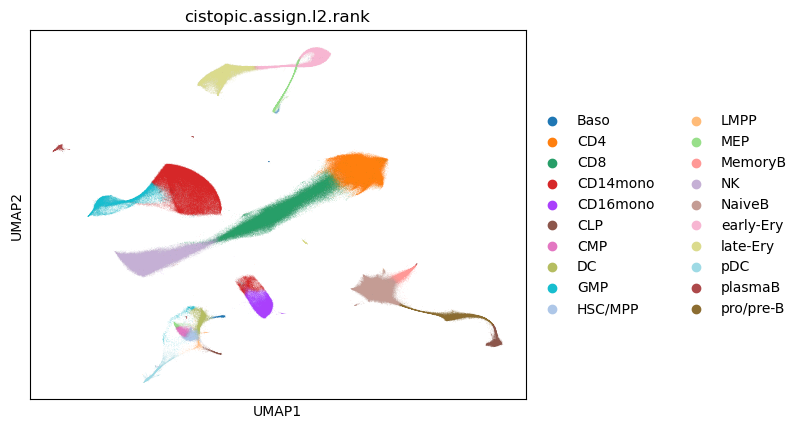

In [108]:
sc.pl.umap(chromvar, color=['cistopic.assign.l2.rank'])


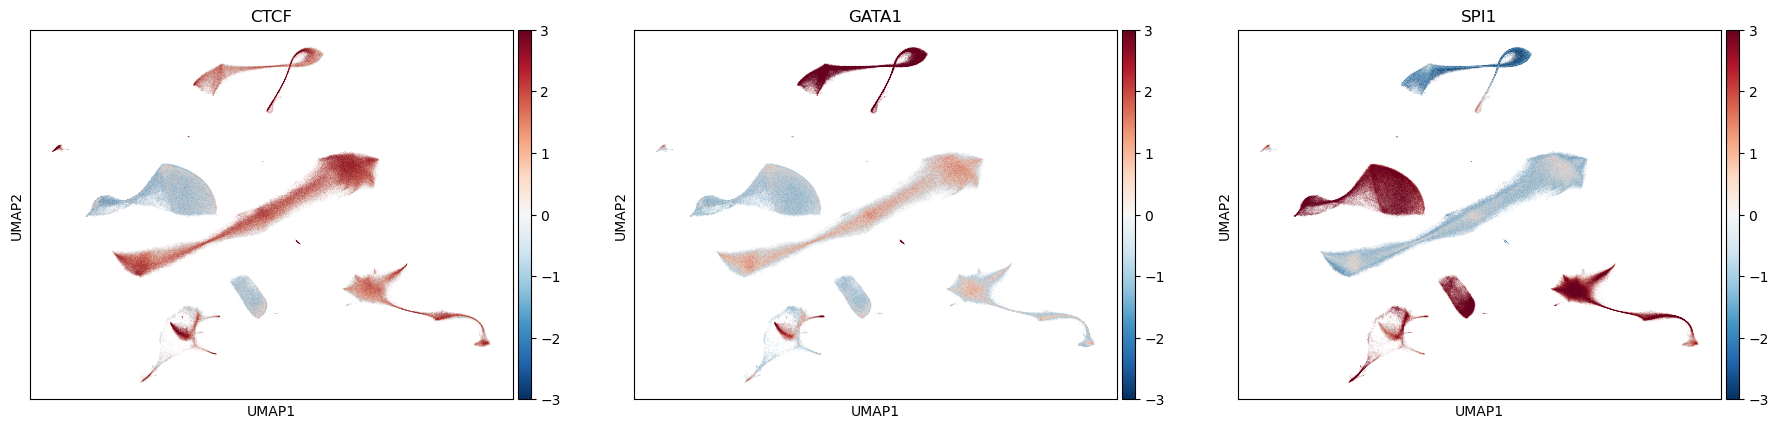

In [110]:
sc.pl.umap(chromvar, color=['CTCF', 'GATA1','SPI1'],cmap='RdBu_r',vmin=-3, vmax=3)


Now for denovo, first call hits (similar to a motif matching)

In [113]:
hits_footprint = scp.tl.seq_denovo_callhits(modisco_output=f'{work_dir}/modisco/modisco.footprint.h5',
                           model_path=model_path,
                           region_path=peak,
                           device='cuda:0',
                           preset='footprint',
                           save_path=f'{work_dir}/modisco/finemo_footprint',
                           overwrite=False,
                           verbose=True,
                           launch=True, # Usually should be True when return_hits=True, but I run it once already
                           return_hits=True)

In [114]:
hits_count = scp.tl.seq_denovo_callhits(modisco_output=f'{work_dir}/modisco/modisco.count.h5',
                           model_path=model_path,
                           region_path=peak,
                           device='cuda:0',
                           preset='count',
                           save_path=f'{work_dir}/modisco/finemo_count',
                           overwrite=False,
                           verbose=True,
                           launch=True,
                           return_hits=True)

Let's take the footprint de-novo motifs as an example

In [134]:
adata = anndata.read_h5ad(f'{work_dir}/cell_peak.h5ad')
# This takes the hits_tsv, and create the motif matching data matrix and motif_name list that chromvar needs
motif_uniq = np.sort(hits_footprint['motif_name'].unique())
motif2id = {m:i for i,m in enumerate(motif_uniq)}
ids = [motif2id[m] for m in hits_footprint['motif_name']]
match_mm = np.zeros((adata.shape[1], len(motif_uniq)))
match_mm[hits_footprint['peak_id'], ids] += 1
match_mm
adata.varm['motif_match'] = match_mm
motif_uniq = [f'footprint_{xx}' for xx in motif_uniq]
adata.uns['motif_name'] = motif_uniq
# Filter after putting in motif match, because, we use all peaks above to call hits
coverage = adata.X.sum(axis=0)
adata = adata[:, coverage > 0]
adata

View of AnnData object with n_obs × n_vars = 833086 × 189258
    uns: 'motif_name'
    varm: 'motif_match'

In [135]:
scp.chromvar.sample_bg_peaks(adata, 
                             genome=scp.genome.hg38, 
                             method='chromvar', 
                             niterations=250)

Fetching GC content:   0%|          | 0/189258 [00:00<?, ?it/s]

Sampling nearest neighbors
NNDescent (2500, 2)


Sampling background peaks:   0%|          | 0/2500 [00:00<?, ?it/s]

array([[ 69490, 173323, 183040, ..., 144711,  81993,  84235],
       [171141, 114331, 139311, ..., 106010, 144677, 153693],
       [ 72558, 155199,  95933, ...,  46145, 176061,   7671],
       ...,
       [157496,  16986, 185852, ..., 147205, 103985, 116210],
       [  9408,  92846, 129160, ..., 116386,  38843,  71779],
       [144126, 173362,   6615, ...,  46828,  17930,  61221]])

In [136]:
chromvar_denovo = scp.chromvar.compute_deviations(adata, chunk_size=50000, device='cuda')

Computing expectation reads per cell and peak...


Processing chunks:   0%|          | 0/17 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

Processing background peaks:   0%|          | 0/250 [00:00<?, ?it/s]

In [141]:
chromvar_denovo.obsm['X_umap'] = vec
chromvar_denovo.obs = cell_type.loc[chromvar.obs.index].copy()

... storing 'sample' as categorical
... storing 'Type' as categorical
... storing 'donor' as categorical
... storing 'cistopic.assign.hg19' as categorical
... storing 'doublet' as categorical
... storing 'cistopic.assign' as categorical
... storing 'cistopic.assign.rank' as categorical
... storing 'cistopic.assign.l2.color' as categorical
... storing 'cistopic.assign.l2' as categorical
... storing 'cistopic.assign.l2.rank' as categorical


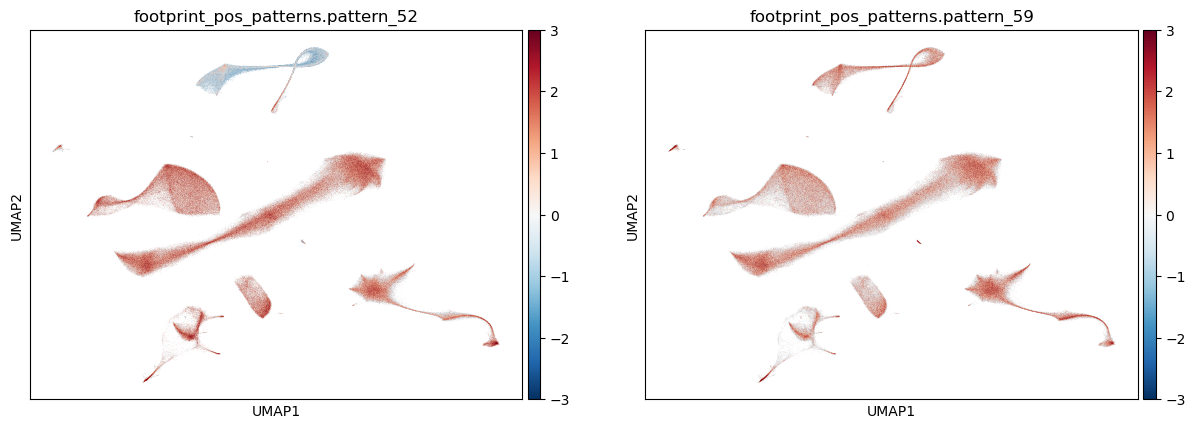

In [143]:
# Based on what's in the modisco report pdf, find interesting ones
sc.pl.umap(chromvar_denovo, color=['footprint_pos_patterns.pattern_52',
                           'footprint_pos_patterns.pattern_59'],cmap='RdBu_r',vmin=-3, vmax=3)


In [145]:
# or find the denovo motifs with high variabilities
var = np.std(chromvar_denovo.X, axis=0)
chromvar_denovo.var.index[np.argsort(var)[::-1][:5]]

Index(['footprint_pos_patterns.pattern_7', 'footprint_pos_patterns.pattern_2',
       'footprint_pos_patterns.pattern_0', 'footprint_pos_patterns.pattern_8',
       'footprint_pos_patterns.pattern_10'],
      dtype='object')

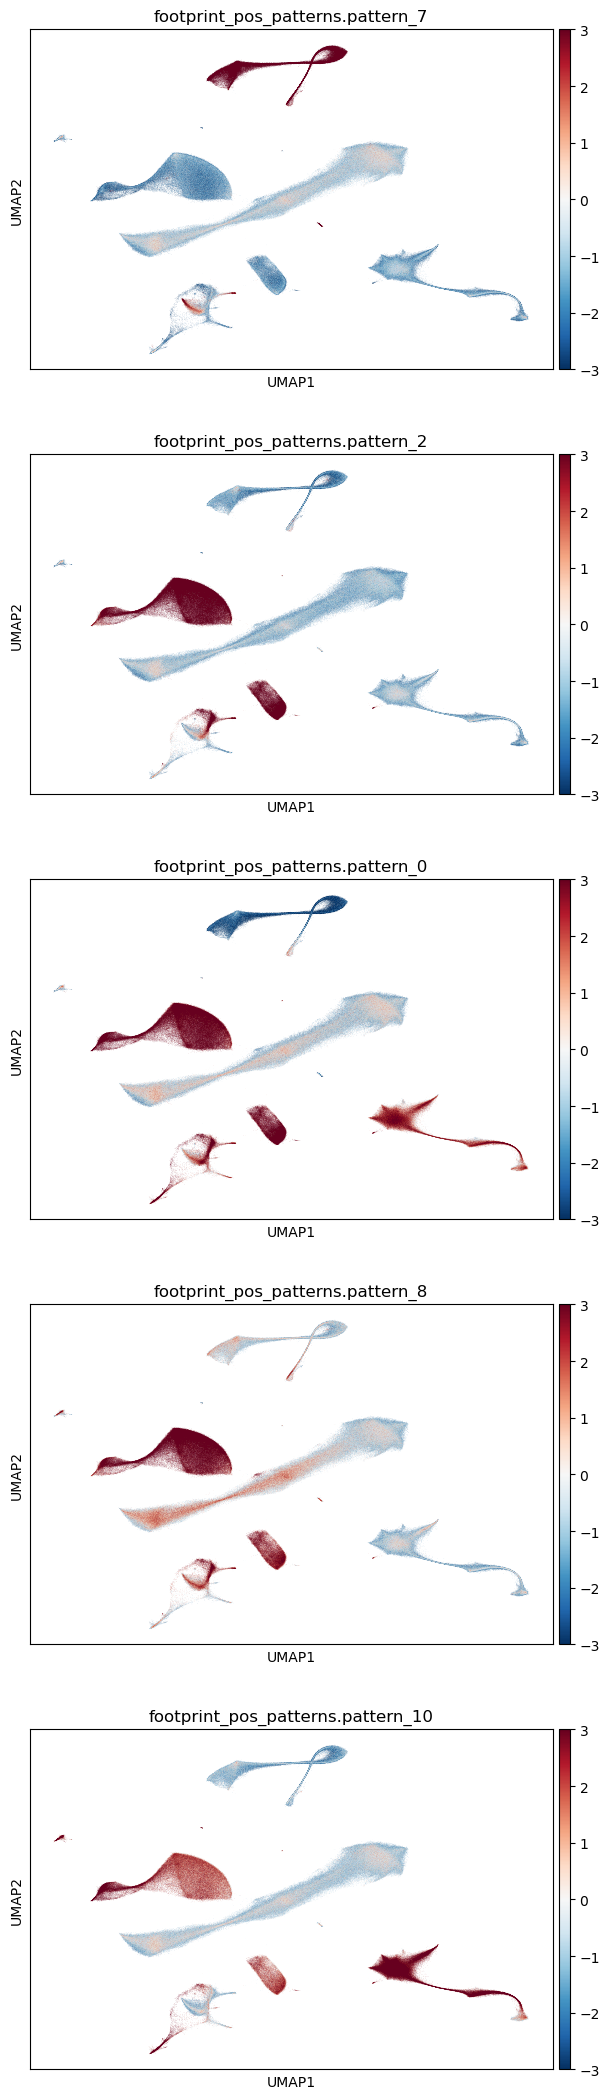

In [146]:
# Based on what's in the modisco report pdf, find interesting ones
sc.pl.umap(chromvar_denovo, color=chromvar_denovo.var.index[np.argsort(var)[::-1][:5]],
           cmap='RdBu_r',vmin=-3, vmax=3, ncols=1)


## Using the cell embeddings for LoRA fintune seq2PRINT models

### Train the LoRA models

You need to locate the trained models, either from wandb or inspecting the local file paths

In [ ]:
# If you do over wandb, you can do this:
# Now fetch models:
import wandb

# Login to your W&B account
wandb.login()

# Set your entity and project
entity = 'ruochiz'  # Replace with your W&B entity (username or team name)
project = 'scPrinter_seq_tutorial'  # Replace with your W&B project name

# Initialize the API
api = wandb.Api()

# Get the project
runs = api.runs(f"{entity}/{project}")
condition2model = {}
for run in runs:
    print (run.name, run.tags)

In [25]:
pretrain_models = ['BMMC_Bulk_fold0-apricot-dew-102.pt',
                  'BMMC_Bulk_fold1-misunderstood-resonance-101.pt',
                  'BMMC_Bulk_fold2-sweet-tree-105.pt',
                  'BMMC_Bulk_fold3-blooming-deluge-103.pt',
                  'BMMC_Bulk_fold4-worthy-pond-104.pt']

In [26]:
cell_grouping, group_names = scp.utils.df2cell_grouping(printer, barcodegroups)

We use single cell embeddings as well as some group specific meta data such as 'Pseudotime' as attribution to LoRA finetune the seq2PRINT models

In [33]:
lora_configs = []
for fold, model in enumerate(pretrain_models):
    lora_config = scp.tl.seq_lora_model_config(printer, 
                                            region_path=f'{work_dir}/seq2print_cleaned_narrowPeak.bed', 
                                            cell_grouping=cell_grouping[:15],
                                            group_names=group_names[:15],
                                            additional_group_attr=groupinfo[[
                                               'Pseudotime',
                                               'MyeloidProbs',
                                               'ErythroidProbs',
                                               'BLymphoidProbs', 
                                               'TLymphoidProbs'
                                            ]].iloc[:15],
                                            embeddings=embeddings,
                                            genome=scp.genome.hg38,
                                            pretrain_model=f'{work_dir}/model/{model}',
                                            overwrite_barcode=False,
                                            model_name=f'BMMC_LoRA_debug',
                                            fold=fold,
                                            model_config=f'{work_dir}/configs/BMMC_fold{fold}.JSON',
                                            additional_lora_config={
                                            "lr":3e-4, # put smaller lr for further fintune
                                            "notes": "v3",
                                            "tags": ["BMMC",
                                                     "Bulk",
                                                     "LoRA",
                                                f"fold{fold}"]},
                                            path_swap=(work_dir, ''),
                                               
                                            config_save_path=f'{work_dir}/configs/BMMC_lora_debug_fold{fold}.JSON')
    break
    lora_configs.append(lora_config)

In [23]:
lora_configs = []
for fold, model in enumerate(pretrain_models):
    lora_config = scp.tl.seq_lora_model_config(printer, 
                                            region_path=f'{work_dir}/seq2print_cleaned_narrowPeak.bed', 
                                            cell_grouping=cell_grouping,
                                            group_names=group_names,
                                            additional_group_attr=groupinfo[[
                                               'Pseudotime',
                                               'MyeloidProbs',
                                               'ErythroidProbs',
                                               'BLymphoidProbs', 
                                               'TLymphoidProbs'
                                            ]],
                                            embeddings=embeddings,
                                            genome=scp.genome.hg38,
                                            pretrain_model=f'{work_dir}/model/{model}',
                                            overwrite_barcode=False,
                                            model_name=f'BMMC_LoRA',
                                            fold=fold,
                                            model_config=f'{work_dir}/configs/BMMC_fold{fold}.JSON',
                                            additional_lora_config={
                                            "lr":3e-4, # put smaller lr for further fintune
                                            "notes": "v3",
                                            "tags": ["BMMC",
                                                     "Bulk",
                                                     "LoRA",
                                                f"fold{fold}"]},
                                            path_swap=(work_dir, ''),
                                               
                                            config_save_path=f'{work_dir}/configs/BMMC_lora_fold{fold}.JSON')
    lora_configs.append(lora_config)

launch the lora training process.
When set launch=True, the process would be launched directly, otherwise it would just print the command.
You'll need to copy the command and run it in the terminal yourself.|

In [18]:
for fold in range(5):
    scp.tl.launch_seq2print(model_config_path=f'{work_dir}/configs/BMMC_lora_fold{fold}.JSON',
                            temp_dir='../PRINT_rev/BMMC_tutorial/temp',
                            model_dir='../PRINT_rev/BMMC_tutorial/model',
                            data_dir='../PRINT_rev/BMMC_tutorial',
                            gpus=fold,
                            wandb_project='scPrinter_seq_tutorial', verbose=True, launch=False)

Please copy the following command in your terminal and run it to start the job
CUDA_VISIBLE_DEVICES=0 seq2print_train --config /data/rzhang/PRINT_rev/BMMC_tutorial/configs/BMMC_lora_fold0.JSON --temp_dir ../PRINT_rev/BMMC_tutorial/temp --model_dir ../PRINT_rev/BMMC_tutorial/model --data_dir ../PRINT_rev/BMMC_tutorial --project scPrinter_seq_tutorial --enable_wandb
Please copy the following command in your terminal and run it to start the job
CUDA_VISIBLE_DEVICES=1 seq2print_train --config /data/rzhang/PRINT_rev/BMMC_tutorial/configs/BMMC_lora_fold1.JSON --temp_dir ../PRINT_rev/BMMC_tutorial/temp --model_dir ../PRINT_rev/BMMC_tutorial/model --data_dir ../PRINT_rev/BMMC_tutorial --project scPrinter_seq_tutorial --enable_wandb
Please copy the following command in your terminal and run it to start the job
CUDA_VISIBLE_DEVICES=2 seq2print_train --config /data/rzhang/PRINT_rev/BMMC_tutorial/configs/BMMC_lora_fold2.JSON --temp_dir ../PRINT_rev/BMMC_tutorial/temp --model_dir ../PRINT_rev/BMMC_

### For the LoRA on 1000 pseudobulks, let's pick some interesting regions to visualize

Now, after the model is trained, we can use the trained LoRA model to interpret some region of interest to see their TF binding score pattern. (or sub-cCRE patterns. )

In [122]:
lora_models = ['BMMC_LoRA_fold0-honest-blaze-236.pt',
               'BMMC_LoRA_fold1-smooth-resonance-233.pt',
               'BMMC_LoRA_fold2-swift-darkness-237.pt',
               'BMMC_LoRA_fold3-glamorous-aardvark-234.pt',
               'BMMC_LoRA_fold4-faithful-field-235.pt'
              ]

regions = ['chr17:40330044-40330843',
'chr20:56411766-56412565',
'chr11:64810286-64811085',
'chr1:84690149-84690948',
'chr3:187739717-187740516',
'chr6:152982910-152983709'] # some interesting regions Yan picked up
regions += ['chr9:132977054-132978495',
'chr11:5280336-5281135',
'chr11:47359003-47360470',
'chr11:47377778-47379245',
'chr11:65661629-65663957',
'chr16:85898074-85899906',
'chr18:79465185-79466227',
'chr19:12994701-12996315',
'chr21:34887982-34889473',
'chr2:61425455-61427302',
'chr6:150682766-150684027',
'chr6:151690691-151691952',
'chr6:151947940-151949201']

regions += [
    'chr1:10917569-10918569',
    'chr1:43568844-43569844',
    'chr11:122856283-122857283',
    'chr1:4603084-4604084',
    'chr1:207362961-207363961',
    'chr6:20319517-20320517',
    'chr1:15965747-15966747',
    'chr8:68259891-68260891',
    'chr2:36441546-36442546',
    'chr8:120808916-120809916',
    'chr2:40455323-40456323',
    'chr13:86882437-86883437',
    'chr2:98026871-98027871',
    'chr3:8712243-8713243',
    'chr2:98663161-98664161',
    'chr3:71087045-71088045',
    'chr2:123738294-123739294',
    'chr3:141949143-141950143',
    'chr1:3890670-3891670',
    'chr4:113355358-113356358'
]

ids = [5,9,13,17,20,29,33,37,50,58,66,69,74,88,91,98,99,100,110,114,115,120,122,125,138,147,165,189,196,205,221,225,241,244,246,250,256,262,263,264,265,281,289,299,300,313,324,328,334,335,384,386,391,396,404,414,416,423,426,427,436,439,454,473,474,478,482,484,488,489,520,522,541,544,546,601,620,632,636,638,643,657,664,673,696,698,701,705,707,715,721,741,747,753,756,767,784,803,805,807,811,828,834,837,853,859,879,880,894,896,897,898,910,911,921,944,949,959,978,981,982,995,998,1000,1,10,14,19,26,32,71,75,179,180,181,186,193,194,198,200,206,208,211,224,230,232,239,242,247,252,259,260,261,270,275,282,292,297,298,304,305,323,325,326,327,333,337,338,342,345,355,365,374,375,380,381,395,405,410,413,420,465,476,493,510,511,517,529,538,542,543,552,567,586,593,599,602,615,644,652,658,666,669,686,702,710,713,714,719,726,727,744,745,748,750,765,771,778,792,821,833,841,848,849,865,867,882,885,893,902,932,935,939,942,954,955,962,965,966,975,976,8,12,15,23,35,40,46,57,65,70,82,85,86,89,101,113,140,149,154,176,183,199,214,222,237,238,251,257,268,277,303,309,310,361,363,368,377,389,400,401,415,417,425,438,442,451,459,466,471,472,494,496,502,504,508,514,518,528,564,592,600,624,651,660,663,671,693,711,720,725,732,734,735,736,758,781,783,799,822,830,840,854,862,864,872,875,889,912,919,920,945,951,952,958,969,970,972,977,979,980,986,991,992,999,330,344,366,398,429,462,483,628,665,694,708,737,780,794,824,866,947,144,430,540,699,112,162,435,441,530,587,746,800,953,18,168,388,437,453,532,582,856,956,129,226,294,308,434,503,560,588,596,625,728,768,782,838,878,16,22,44,45,54,56,60,81,84,93,126,130,134,139,142,156,170,192,201,204,217,253,269,352,354,392,394,445,452,455,464,467,576,581,607,681,704,706,723,739,751,766,806,835,863,871,892,895,901,923,924,946,4,42,59,63,109,111,141,143,184,197,209,213,231,283,302,306,316,343,358,360,372,383,403,408,440,447,460,469,533,548,555,570,583,585,595,606,610,611,618,637,662,684,697,700,718,761,777,789,808,810,816,818,839,845,850,876,899,906,913,929,974,985,987,996,997,30,34,64,97,124,171,190,218,279,329,443,461,485,575,594,621,646,692,733,738,770,773,801,829,831,836,844,860,881,883,886,904,909,933,973,2,41,53,73,96,105,128,161,175,178,210,271,320,322,359,367,406,458,463,470,479,506,513,523,561,566,603,634,635,648,674,688,755,787,827,842,858,873,927,937,943,3,6,21,31,39,43,47,48,51,52,68,76,80,90,103,106,107,116,137,148,150,151,153,158,160,173,182,185,188,202,203,207,212,220,223,229,236,240,243,248,255,266,272,274,276,280,284,285,286,288,291,295,312,314,315,317,318,331,332,339,340,348,353,356,357,362,364,369,376,378,379,397,402,411,412,418,422,432,450,457,475,481,487,492,498,501,507,516,519,521,526,531,545,550,553,554,559,562,563,568,574,590,591,597,605,608,613,614,616,619,626,627,629,639,641,649,650,659,667,668,670,672,676,679,683,685,689,695,703,709,717,722,724,729,740,742,743,752,754,757,759,762,769,774,775,788,795,797,802,804,817,819,820,823,826,846,847,852,855,861,868,870,877,884,891,900,905,915,917,918,922,931,936,938,948,960,964,967,968,971,984,993,49,67,78,79,87,159,187,191,219,346,419,468,480,490,578,598,630,642,654,682,716,764,772,790,812,815,874,930,934,940,94,102,131,155,301,321,524,551,558,832,961,990,350,534,760,925,7,11,24,28,38,61,83,92,95,117,118,119,127,132,133,146,152,157,163,164,166,167,172,174,195,216,227,233,245,249,254,267,273,278,287,296,307,336,341,347,349,351,370,371,385,390,393,407,409,424,428,431,444,449,456,477,491,495,497,499,500,505,509,515,527,537,539,571,572,577,579,580,584,612,617,623,631,633,645,653,655,656,677,690,712,730,749,763,779,785,786,791,798,813,843,851,857,887,888,908,926,928,957,963,983,989,77,108,136,145,293,311,421,525,556,565,622,691,25,36,62,121,123,169,177,228,234,235,290,373,382,387,446,448,569,589,604,640,647,661,675,678,776,796,809,869,903,950,27,55,72,104,135,215,258,319,399,433,486,512,535,536,547,549,557,573,609,680,687,731,793,814,825,890,907,914,916,941,988,994]
ids = np.array(ids) - 1 # reorder the ids to group by cell types
regions = scp.utils.regionparser(regions)
regions = scp.utils.resize_bed_df(regions, 1000)
regions.to_csv(f'{work_dir}/example_region1.bed', sep='\t', index=False, header=False)

In [123]:
vs = scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                          seq_attr_footprint=None,
                          genome=printer.genome,
                          region_path=f'{work_dir}/example_region1.bed',
                          gpus=[0,1,2,3,4,5,6,7],
                          model_type='lora',
                          model_path=[os.path.join(work_dir, 'model', m) for m in lora_models],
                          lora_config=lora_config,
                          group_names=group_names,
                          verbose=False,
                          launch=True,
                          return_adata=True, # turn this as True
                          overwrite_seqattr=False,
                          save_key='BMMC_bulklora_example_region1', # and input a save_key 
                          save_path=work_dir)

seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold0-honest-blaze-236.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_region1.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key BMMC_bulklora_example_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,1

fetching coverage: 100%|██████████| 39/39 [00:00<00:00, 4693.23it/s]


[375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 375:   0%|          | 0/125 [00:00<?, ?it/s]

[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624]
[4]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 500:   0%|          | 0/125 [00:00<?, ?it/s]

[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 125:   0%|          | 0/125 [00:00<?, ?it/s]

[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 250:   0%|          | 0/125 [00:00<?, ?it/s]

[750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874]
[6]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,

working on 0:   0%|          | 0/125 [00:00<?, ?it/s]

(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]
[7]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 

working on 749: 100%|██████████| 125/125 [18:12<00:00,  8.74s/it]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold1-smooth-resonance-233.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_region1.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key BMMC_bulklora_example_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,1

fetching coverage: 100%|██████████| 39/39 [00:00<00:00, 4661.13it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 0:   0%|          | 0/125 [00:00<?, ?it/s]

[875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]
[7]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 875:   0%|          | 0/125 [00:00<?, ?it/s]

[625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749]
[5]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 625:   0%|          | 0/125 [00:00<?, ?it/s]

[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624]
[4]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 500:   0%|          | 0/125 [00:00<?, ?it/s]

[750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874]
[6]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 750:   0%|          | 0/125 [00:00<?, ?it/s]

[375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 

working on 249: 100%|██████████| 125/125 [18:12<00:00,  8.74s/it]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold2-swift-darkness-237.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_region1.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key BMMC_bulklora_example_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194

fetching coverage: 100%|██████████| 39/39 [00:00<00:00, 4674.86it/s]


[750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874]
[6]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 750:   0%|          | 0/125 [00:00<?, ?it/s]

[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624]
[4]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 500:   0%|          | 0/125 [00:00<?, ?it/s]

[875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]
[7]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 875:   0%|          | 0/125 [00:00<?, ?it/s]

[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 125:   0%|          | 0/125 [00:00<?, ?it/s]

[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 250:   0%|          | 0/125 [00:00<?, ?it/s]

[375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 

working on 0:   0%|          | 0/125 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 374: 100%|██████████| 125/125 [18:14<00:00,  8.76s/it]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold3-glamorous-aardvark-234.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_region1.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key BMMC_bulklora_example_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193

fetching coverage: 100%|██████████| 39/39 [00:00<00:00, 4669.92it/s]


[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624]
[4]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 500:   0%|          | 0/125 [00:00<?, ?it/s]

[875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]
[7]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 875:   0%|          | 0/125 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 0:   0%|          | 0/125 [00:00<?, ?it/s]

[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 250:   0%|          | 0/125 [00:00<?, ?it/s]

[750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874]
[6]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 750:   0%|          | 0/125 [00:00<?, ?it/s]

[375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 375:   0%|          | 0/125 [00:00<?, ?it/s]

[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 

working on 374: 100%|██████████| 125/125 [18:15<00:00,  8.76s/it]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold4-faithful-field-235.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_region1.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key BMMC_bulklora_example_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194

fetching coverage: 100%|██████████| 39/39 [00:00<00:00, 4675.26it/s]


[750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874]
[6]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 750:   0%|          | 0/125 [00:00<?, ?it/s]

[875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]
[7]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 875:   0%|          | 0/125 [00:00<?, ?it/s]

[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624]
[4]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 500:   0%|          | 0/125 [00:00<?, ?it/s]

[375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 375:   0%|          | 0/125 [00:00<?, ?it/s]

[625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749]
[5]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 

working on 374: 100%|██████████| 125/125 [18:14<00:00,  8.76s/it]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold0-honest-blaze-236.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_region1.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key BMMC_bulklora_example_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193

fetching coverage: 100%|██████████| 39/39 [00:00<00:00, 4667.39it/s]


[375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 375:   0%|          | 0/125 [00:00<?, ?it/s]

[625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749]
[5]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 

working on 125:   0%|          | 0/125 [00:00<?, ?it/s]

[750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874]
[6]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 750:   0%|          | 0/125 [00:00<?, ?it/s]

[875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]
[7]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 875:   0%|          | 0/125 [00:00<?, ?it/s]

[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624]
[4]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 500:   0%|          | 0/125 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 

working on 624: 100%|██████████| 125/125 [18:32<00:00,  8.90s/it]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold1-smooth-resonance-233.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_region1.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key BMMC_bulklora_example_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192

fetching coverage: 100%|██████████| 39/39 [00:00<00:00, 4678.33it/s]


[625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749]
[5]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 625:   0%|          | 0/125 [00:00<?, ?it/s]

[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,

working on 0:   0%|          | 0/125 [00:00<?, ?it/s]

[375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 375:   0%|          | 0/125 [00:00<?, ?it/s]

[750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874]
[6]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 750:   0%|          | 0/125 [00:00<?, ?it/s]

[875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]
[7]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 875:   0%|          | 0/125 [00:00<?, ?it/s]

[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624]
[4]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 

working on 249: 100%|██████████| 125/125 [18:29<00:00,  8.88s/it]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold2-swift-darkness-237.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_region1.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key BMMC_bulklora_example_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,1

fetching coverage: 100%|██████████| 39/39 [00:00<00:00, 4695.79it/s]


[750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874]
[6]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 750:   0%|          | 0/125 [00:00<?, ?it/s]

[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 250:   0%|          | 0/125 [00:00<?, ?it/s]

[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624]
[4]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 500:   0%|          | 0/125 [00:00<?, ?it/s]

[625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749]
[5]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 625:   0%|          | 0/125 [00:00<?, ?it/s]

[875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]
[7]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 

working on 375:   0%|          | 0/125 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 999: 100%|██████████| 125/125 [18:59<00:00,  9.11s/it]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold3-glamorous-aardvark-234.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_region1.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key BMMC_bulklora_example_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,1

fetching coverage: 100%|██████████| 39/39 [00:00<00:00, 4659.81it/s]


[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 125:   0%|          | 0/125 [00:00<?, ?it/s]

[625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749]
[5]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,

working on 0:   0%|          | 0/125 [00:00<?, ?it/s]

[750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874]
[6]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 750:   0%|          | 0/125 [00:00<?, ?it/s]

[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 

working on 875:   0%|          | 0/125 [00:00<?, ?it/s]

[375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 

working on 999: 100%|██████████| 125/125 [18:56<00:00,  9.09s/it]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold4-faithful-field-235.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_region1.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 1 2 3 4 5 6 7 --genome hg38 --decay 0.85 --save_key BMMC_bulklora_example_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,1

fetching coverage: 100%|██████████| 39/39 [00:00<00:00, 4682.21it/s]


[625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749]
[5]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 625:   0%|          | 0/125 [00:00<?, ?it/s]

[375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 375:   0%|          | 0/125 [00:00<?, ?it/s]

[875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]
[7]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 

working on 125:   0%|          | 0/125 [00:00<?, ?it/s]

[250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39
[750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 

working on 750:   0%|          | 0/125 [00:00<?, ?it/s]

[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624]
[4]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 500:   0%|          | 0/125 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 39
valid summits after trimming edges 39
(39, 1)
coverage min max 805.34 990.9771
valid summits after min/max count filter 39


working on 999: 100%|██████████| 125/125 [18:43<00:00,  8.99s/it]


seq2print_tfbs --count_pt /home/rzhang/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/rzhang/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold4-faithful-field-235.pt_BMMC_bulklora_example_region1/model_{lora_id}.attr.count.shap_hypo_0_.0.85.npz --seq_foot /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold4-faithful-field-235.pt_BMMC_bulklora_example_region1/model_{lora_id}.attr.just_sum.shap_hypo_0-30_.0.85.npz --genome hg38 --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_region1.bed --save_name /data/rzhang/PRINT_rev/BMMC_tutorial/1,/data/rzhang/PRINT_rev/BMMC_tutorial/2,/data/rzhang/PRINT_rev/BMMC_tutorial/3,/data/rzhang/PRINT_rev/BMMC_tutorial/4,/data/rzhang/PRINT_rev/BMMC_tutorial/5,/data/rzhang/PRINT_rev/BMMC_tutorial/6,/data/rzhang/PRINT_rev/BMMC_tutorial/7,/data/rzhang/PRINT_rev/BMMC_tutorial/8,/data/rzhang/PRINT_rev/BMMC_tutorial/9,/data/rzhang/PRINT_rev/BMMC_tutorial/10,/data/rzhang/PRINT_rev/BMMC_tutorial/

  0%|          | 0/4875 [00:00<?, ?it/s]

gpu 6


 22%|██▏       | 1092/4875 [00:00<00:01, 2614.13it/s]

gpu 0
gpu 1
gpu 5


 90%|████████▉ | 4368/4875 [00:00<00:00, 14364.94it/s]


['seq2print_tfbs', '--count_pt', '/home/rzhang/.cache/scprinter/TFBS_0_conv_v2.pt', '--foot_pt', '/home/rzhang/.cache/scprinter/TFBS_1_conv_v2.pt', '--seq_count', '/data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold4-faithful-field-235.pt_BMMC_bulklora_example_region1/model_{lora_id}.attr.count.shap_hypo_0_.0.85.npz', '--seq_foot', '/data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_LoRA_fold4-faithful-field-235.pt_BMMC_bulklora_example_region1/model_{lora_id}.attr.just_sum.shap_hypo_0-30_.0.85.npz', '--genome', 'hg38', '--peaks', '/data/rzhang/PRINT_rev/BMMC_tutorial/example_region1.bed', '--gpus', '7', '--lora_ids', '875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,96

/home/rzhang/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.


In [ ]:
# reorder the pseudobulks by their cell type order
ids = [5,9,13,17,20,29,33,37,50,58,66,69,74,88,91,98,99,100,110,114,115,120,122,125,138,147,165,189,196,205,221,225,241,244,246,250,256,262,263,264,265,281,289,299,300,313,324,328,334,335,384,386,391,396,404,414,416,423,426,427,436,439,454,473,474,478,482,484,488,489,520,522,541,544,546,601,620,632,636,638,643,657,664,673,696,698,701,705,707,715,721,741,747,753,756,767,784,803,805,807,811,828,834,837,853,859,879,880,894,896,897,898,910,911,921,944,949,959,978,981,982,995,998,1000,1,10,14,19,26,32,71,75,179,180,181,186,193,194,198,200,206,208,211,224,230,232,239,242,247,252,259,260,261,270,275,282,292,297,298,304,305,323,325,326,327,333,337,338,342,345,355,365,374,375,380,381,395,405,410,413,420,465,476,493,510,511,517,529,538,542,543,552,567,586,593,599,602,615,644,652,658,666,669,686,702,710,713,714,719,726,727,744,745,748,750,765,771,778,792,821,833,841,848,849,865,867,882,885,893,902,932,935,939,942,954,955,962,965,966,975,976,8,12,15,23,35,40,46,57,65,70,82,85,86,89,101,113,140,149,154,176,183,199,214,222,237,238,251,257,268,277,303,309,310,361,363,368,377,389,400,401,415,417,425,438,442,451,459,466,471,472,494,496,502,504,508,514,518,528,564,592,600,624,651,660,663,671,693,711,720,725,732,734,735,736,758,781,783,799,822,830,840,854,862,864,872,875,889,912,919,920,945,951,952,958,969,970,972,977,979,980,986,991,992,999,330,344,366,398,429,462,483,628,665,694,708,737,780,794,824,866,947,144,430,540,699,112,162,435,441,530,587,746,800,953,18,168,388,437,453,532,582,856,956,129,226,294,308,434,503,560,588,596,625,728,768,782,838,878,16,22,44,45,54,56,60,81,84,93,126,130,134,139,142,156,170,192,201,204,217,253,269,352,354,392,394,445,452,455,464,467,576,581,607,681,704,706,723,739,751,766,806,835,863,871,892,895,901,923,924,946,4,42,59,63,109,111,141,143,184,197,209,213,231,283,302,306,316,343,358,360,372,383,403,408,440,447,460,469,533,548,555,570,583,585,595,606,610,611,618,637,662,684,697,700,718,761,777,789,808,810,816,818,839,845,850,876,899,906,913,929,974,985,987,996,997,30,34,64,97,124,171,190,218,279,329,443,461,485,575,594,621,646,692,733,738,770,773,801,829,831,836,844,860,881,883,886,904,909,933,973,2,41,53,73,96,105,128,161,175,178,210,271,320,322,359,367,406,458,463,470,479,506,513,523,561,566,603,634,635,648,674,688,755,787,827,842,858,873,927,937,943,3,6,21,31,39,43,47,48,51,52,68,76,80,90,103,106,107,116,137,148,150,151,153,158,160,173,182,185,188,202,203,207,212,220,223,229,236,240,243,248,255,266,272,274,276,280,284,285,286,288,291,295,312,314,315,317,318,331,332,339,340,348,353,356,357,362,364,369,376,378,379,397,402,411,412,418,422,432,450,457,475,481,487,492,498,501,507,516,519,521,526,531,545,550,553,554,559,562,563,568,574,590,591,597,605,608,613,614,616,619,626,627,629,639,641,649,650,659,667,668,670,672,676,679,683,685,689,695,703,709,717,722,724,729,740,742,743,752,754,757,759,762,769,774,775,788,795,797,802,804,817,819,820,823,826,846,847,852,855,861,868,870,877,884,891,900,905,915,917,918,922,931,936,938,948,960,964,967,968,971,984,993,49,67,78,79,87,159,187,191,219,346,419,468,480,490,578,598,630,642,654,682,716,764,772,790,812,815,874,930,934,940,94,102,131,155,301,321,524,551,558,832,961,990,350,534,760,925,7,11,24,28,38,61,83,92,95,117,118,119,127,132,133,146,152,157,163,164,166,167,172,174,195,216,227,233,245,249,254,267,273,278,287,296,307,336,341,347,349,351,370,371,385,390,393,407,409,424,428,431,444,449,456,477,491,495,497,499,500,505,509,515,527,537,539,571,572,577,579,580,584,612,617,623,631,633,645,653,655,656,677,690,712,730,749,763,779,785,786,791,798,813,843,851,857,887,888,908,926,928,957,963,983,989,77,108,136,145,293,311,421,525,556,565,622,691,25,36,62,121,123,169,177,228,234,235,290,373,382,387,446,448,569,589,604,640,647,661,675,678,776,796,809,869,903,950,27,55,72,104,135,215,258,319,399,433,486,512,535,536,547,549,557,573,609,680,687,731,793,814,825,890,907,914,916,941,988,994]
ids = np.array(ids) - 1
pred = vs
for i in range(pred.shape[1]):
    plt.figure()
    sns.heatmap(pred[ids][:, i], vmax=0.2, vmin=0.0, cmap='RdBu_r', cbar=False)
    plt.axis('off')
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)

In [148]:
printer.close()

1000 pseudobulks are a lot. so we try to avoid genome wide or cCRE wide analysis, but focused on picking regions for analysis and visualization

## seq2PRINT reveals the TF binding dynamics for Erythroid development trajectory

We would "slice" the 150 ish pseudobulks that belong to the Erythroid development trajectories within those 1000 pseudobulks we just LoRA fintuned on, and further finetune them.

### Train the Ery-specific lora models

In [26]:
lora_models = ['BMMC_LoRA_fold0-honest-blaze-236.pt',
               'BMMC_LoRA_fold1-smooth-resonance-233.pt',
               'BMMC_LoRA_fold2-swift-darkness-237.pt',
               'BMMC_LoRA_fold3-glamorous-aardvark-234.pt',
               'BMMC_LoRA_fold4-faithful-field-235.pt'
              ]


In [27]:
temp_group = groupinfo.loc[(np.argmax(np.array(groupinfo.iloc[:, -4:]), axis=-1) == 1) & groupinfo['cellType'].isin(["HSC/MPP", "CMP", "MEP", "early-Ery", "late-Ery"])]
time = temp_group['Pseudotime']
Ery_group_names = temp_group['groupID']
Ery_group_names = list(np.array(Ery_group_names)[np.argsort(time)])
groupinfo.index = groupinfo['groupID']
barcodegroups_cluster = barcodegroups.groupby('group')
ery_bcs = [np.array(barcodegroups_cluster.get_group(g)['barcode']) for g in Ery_group_names]
ery_bcs = list(np.unique(ery_bcs))

In [114]:
# Use barcodes presented in Erythroid development trajectories, and call peaks
scp.pp.call_peaks(printer=printer, 
                  frag_file=frag,
                  cell_grouping=[ery_bcs], # here we call peaks on the cells that are included in the final analyses
                  group_names=['Ery_dev'], 
                  preset='seq2PRINT')

INFO  @ Mon, 19 Aug 2024 10:56:49: 
# Command line: callpeak --nomodel -t /data/rzhang/PRINT_rev/BMMC_tutorial/scprinter_supp/Ery_dev_filtered_frag.tsv.gz --outdir /data/rzhang/PRINT_rev/BMMC_tutorial/scprinter_supp/macs2 -n Ery_dev -f BEDPE --nolambda --keep-dup all --call-summits --nomodel -B --SPMR --shift 75 --extsize 150 -p 0.01
# ARGUMENTS LIST:
# name = Ery_dev
# format = BEDPE
# ChIP-seq file = ['/data/rzhang/PRINT_rev/BMMC_tutorial/scprinter_supp/Ery_dev_filtered_frag.tsv.gz']
# control file = None
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# pvalue cutoff = 1.00e-02
# qvalue will not be calculated and reported as -1 in the final output.
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 10000 bps
# Broad region calling is off
# Pai

Reading in peak summit file(s):
NOTE: Assuming all start coordinates are 0-based ..

Padding peak summits by: 500 bp on either side for
Removing peaks overlapping with blacklisted regions and out of bound peaks based on chromosome sizes ..

Filtering overlapping peaks based on peak summit score ..
round: 1 297680 peaks unresolved 296327 peaks selected
round: 2 33 peaks unresolved 33 peaks selected
finish clearing
finish sorting
finished summary


In [153]:
# fetched the cleaned peaks, save, it will be used in the next step
cleaned_peaks = pd.DataFrame(printer.uns["peak_calling"]['Ery_dev_cleaned'][:])
cleaned_peaks.to_csv(f'{work_dir}/seq2print_cleaned_narrowPeak_Ery_dev.bed', 
                     sep='\t', header=False, index=False)

cleaned_peaks

,0,1,2,3,4,5,6,7
0,chr1,816833,817833,Ery_dev_peak_8,75.9214,75.9214,Ery_dev,48479
1,chr1,820912,821912,Ery_dev_peak_9,2.84392,2.84392,Ery_dev,258078
2,chr1,827022,828022,Ery_dev_peak_10,1381.6,1381.6,Ery_dev,7341
3,chr1,828840,829840,Ery_dev_peak_11a,27.238,27.238,Ery_dev,83052
4,chr1,829237,830237,Ery_dev_peak_11b,11.7093,11.7093,Ery_dev,126347
...,...,...,...,...,...,...,...,...
296355,chrX,155640983,155641983,Ery_dev_peak_147496,2.01487,2.01487,Ery_dev,291474
296356,chrX,155650878,155651878,Ery_dev_peak_147497,4.14397,4.14397,Ery_dev,216081
296357,chrX,155661992,155662992,Ery_dev_peak_147498,6.46679,6.46679,Ery_dev,173723
296358,chrX,155666488,155667488,Ery_dev_peak_147499,4.50136,4.50136,Ery_dev,210717


In [28]:
lora_slice_configs = []
for fold, model in enumerate(lora_models):
    lora_slice_config = scp.tl.seq_lora_slice_model_config(
                                            region_path=f'{work_dir}/seq2print_cleaned_narrowPeak_Ery_dev.bed', 
                                            lora_config=f'{work_dir}/configs/BMMC_lora_fold{fold}.JSON',
                                            pretrained_lora_model=f'{work_dir}/model/{model}',
                                            model_name=f'BMMC_Ery_LoRA',
                                            finetune_group_names=Ery_group_names,
                                            fold=fold,
                                            additional_lora_config={
                                            "lr":3e-4, # put smaller lr for further fintune
                                            "notes": "v3",
                                            "tags": ["BMMC",
                                                     "Ery",
                                                     "LoRA",
                                                f"fold{fold}"]},  
                                            path_swap=(work_dir, ''),
                                            config_save_path=f'{work_dir}/configs/Ery_lora_fold{fold}.JSON')
    lora_slice_configs.append(lora_slice_config)

In [29]:
for fold in range(5):
    scp.tl.launch_seq2print(model_config_path=f'{work_dir}/configs/Ery_lora_fold{fold}.JSON',
                            temp_dir='../PRINT_rev/BMMC_tutorial/temp',
                            model_dir='../PRINT_rev/BMMC_tutorial/model',
                            data_dir='../PRINT_rev/BMMC_tutorial',
                            gpus=fold,
                            wandb_project='scPrinter_seq_tutorial', verbose=True, launch=False)

Please copy the following command in your terminal and run it to start the job
CUDA_VISIBLE_DEVICES=0 seq2print_train --config /data/rzhang/PRINT_rev/BMMC_tutorial/configs/Ery_lora_fold0.JSON --temp_dir ../PRINT_rev/BMMC_tutorial/temp --model_dir ../PRINT_rev/BMMC_tutorial/model --data_dir ../PRINT_rev/BMMC_tutorial --project scPrinter_seq_tutorial --enable_wandb
Please copy the following command in your terminal and run it to start the job
CUDA_VISIBLE_DEVICES=1 seq2print_train --config /data/rzhang/PRINT_rev/BMMC_tutorial/configs/Ery_lora_fold1.JSON --temp_dir ../PRINT_rev/BMMC_tutorial/temp --model_dir ../PRINT_rev/BMMC_tutorial/model --data_dir ../PRINT_rev/BMMC_tutorial --project scPrinter_seq_tutorial --enable_wandb
Please copy the following command in your terminal and run it to start the job
CUDA_VISIBLE_DEVICES=2 seq2print_train --config /data/rzhang/PRINT_rev/BMMC_tutorial/configs/Ery_lora_fold2.JSON --temp_dir ../PRINT_rev/BMMC_tutorial/temp --model_dir ../PRINT_rev/BMMC_tut

### Quick inspection

Visualize the observed footprints and predicted one. We can also get the TFBS scores in some example regions

In [102]:
Ery_lora_models = ['BMMC_Ery_LoRA_fold0-lunar-snowflake-241.pt',
                  'BMMC_Ery_LoRA_fold1-genial-bush-238.pt',
                  'BMMC_Ery_LoRA_fold2-autumn-rain-238.pt',
                  'BMMC_Ery_LoRA_fold3-glowing-vortex-238.pt',
                  'BMMC_Ery_LoRA_fold4-youthful-grass-242.pt']
temp_group = groupinfo.loc[(np.argmax(np.array(groupinfo.iloc[:, -4:]), axis=-1) == 1) & groupinfo['cellType'].isin(["HSC/MPP", "CMP", "MEP", "early-Ery", "late-Ery"])]
time = temp_group['Pseudotime']
Ery_group_names = temp_group['groupID']
Ery_group_names = list(np.array(Ery_group_names)[np.argsort(time)])
barcodegroup_grouped = barcodegroups.groupby('group')
Ery_cell_grouping = [list(barcodegroup_grouped.get_group(x)['barcode']) for x in tqdm(Ery_group_names)]

  0%|          | 0/135 [00:00<?, ?it/s]

get the observed footprints

In [106]:
scp.tl.get_footprint_score(printer,
                       save_key='test_region',
                       cell_grouping=Ery_cell_grouping,
                       group_names=Ery_group_names, 
                       regions = ["chr11:5284262-5285262"], backed=True, overwrite=True)

estimated file size: 0.05 GB
Creating test_region in printer.footprintsadata
obs=groups, var=regions
118 100
Loading insertion profiles


Submitting jobs:   0%|          | 0/99 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/99 [00:00<?, ?it/s]

<Axes: >

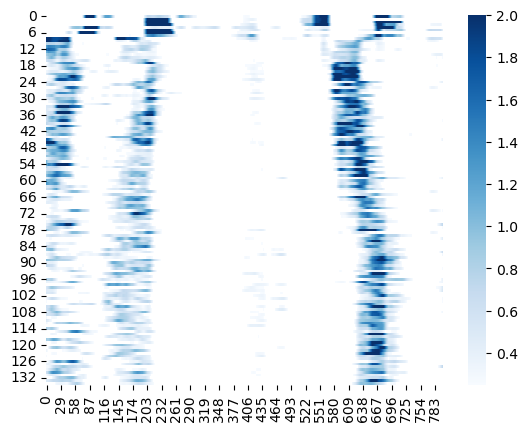

In [107]:
footprint_adata = printer.footprintsadata['test_region']
footprints = footprint_adata.obsm["chr11:5284262-5285262"]
fp = footprints[:, 48, 100:-100].copy()
fp[fp <= 0.25] = np.nan
sns.heatmap(fp, cmap='Blues', vmin=0.25, vmax=2.0)

now the model predicted ones

In [108]:
chr = 'chr11'
start = 5284262
end = 5285262

center = (start + end) // 2
pad = 1840 // 2
start = center-pad
end = center+pad
seq = scp.genome.hg38.fetch_onehot_seq(chr, 
                               center-pad, 
                               center+pad)[None]
seq.shape

torch.Size([1, 4, 1840])

In [109]:
models = [torch.load(os.path.join(work_dir, 'model', path),
                     map_location='cpu', weights_only=False) for path in Ery_lora_models]
for model in models:
    model.eval()
    # Set coverage to be the same
    mm =  model.coverages.weight.data[:, -1].mean()
    model.coverages.weight.data[:, -1] = mm


In [110]:
footprints_avg = []
baseline_avg = []
counts_avg = []
for model in models:
    model_ori = model.return_origin()
    model = model.cuda()
    model_ori = model_ori.cuda()
    footprints = []
    baseline = []
    counts = []
    with torch.no_grad():
        # for i in tqdm(order):
        for i in trange(len(Ery_cell_grouping)):
            pred_ori = model(seq.cuda().float(), torch.as_tensor([i]).long().cuda())
            model_0 = model.collapse(int(i))
            model_0 = model_0.cuda()
            model_0.eval()
            pred = model_0(seq.cuda().float(), cells=torch.as_tensor([i]).long().cuda())
            # print (pred_ori[1] - pred[1])
            footprints.append(pred[0][0].detach().cpu().numpy())
            counts.append(pred[1].detach().cpu().numpy())
            # model.dna_cnn_model.conv.scale = 0.0
            pred = model_ori(seq.cuda().float())
            baseline.append(pred[0][0].detach().cpu().numpy())
    footprints = np.array(footprints)
    baseline = np.array(baseline)
    counts = np.array(counts).reshape((-1))
    footprints_avg.append(footprints)
    baseline_avg.append(baseline)
    counts_avg.append(counts)
    model = model.cpu()
    model_ori = model_ori.cpu()
    break
footprints_avg = np.array(footprints_avg)
baseline_avg = np.array(baseline_avg)
counts_avg = np.array(counts_avg)

  0%|          | 0/135 [00:00<?, ?it/s]

model predicted nucleosome-scale footprints

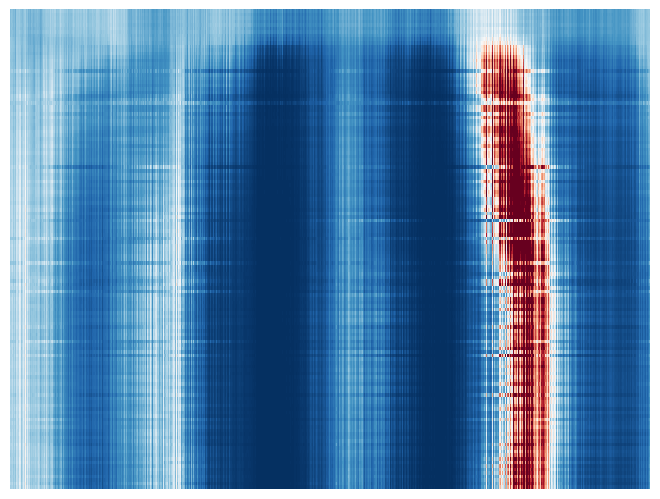

In [111]:
xx = scp.utils.zscore2pval(footprints_avg.mean(axis=0))  #-  scp.utils.zscore2pval(baseline)
sns.heatmap(xx[:, 50, :], cmap='RdBu_r',cbar=False, vmax=0.75)
plt.axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1)
# plt.savefig('pred_lora_peak.png')

now let's calculate and visualize the sequence based TF binding score in this region

In [113]:
regions = scp.utils.regionparser(["chr11:5284262-5285262"])
regions.to_csv(f'{work_dir}/example_ery_region1.bed', sep='\t', header=False, index=False)

In [114]:
import json
adata_ery_tfbs = scp.tl.seq_tfbs_seq2print(seq_attr_count=None,
                          seq_attr_footprint=None,
                          genome=printer.genome,
                          region_path=f'{work_dir}/example_ery_region1.bed',
                          gpus=[0,1,2,3],
                          model_type='lora',
                          model_path=[os.path.join(work_dir, 'model', m) for m in Ery_lora_models],
                          lora_config=json.load(open(f'{work_dir}/configs/Ery_lora_fold0.JSON', 'r')),
                          group_names=Ery_group_names,
                          verbose=False,
                          launch=True,
                          return_adata=True, # turn this as True
                          overwrite_seqattr=False,
                          save_key='BMMC_Ery_lora_example_ery_region1', # and input a save_key 
                          save_path=work_dir)

seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold0-lunar-snowflake-241.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_ery_region1.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 1 2 3 --genome hg38 --decay 0.85 --save_key BMMC_Ery_lora_example_ery_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134 --model_norm count --silent 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53

fetching coverage: 100%|██████████| 1/1 [00:00<00:00, 2339.27it/s]


[102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1
[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 104:   6%|▌         | 2/33 [00:01<00:16,  1.84it/s]

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 0:   0%|          | 0/34 [00:00<?, ?it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 33: 100%|██████████| 34/34 [00:09<00:00,  3.40it/s]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold1-genial-bush-238.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_ery_region1.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 1 2 3 --genome hg38 --decay 0.85 --save_key BMMC_Ery_lora_example_ery_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134 --model_norm count --silent 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54

fetching coverage: 100%|██████████| 1/1 [00:00<00:00, 2455.68it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1
[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 2:   6%|▌         | 2/34 [00:01<00:17,  1.87it/s]]

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 4:  12%|█▏        | 4/34 [00:01<00:10,  2.82it/s]

[102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 134: 100%|██████████| 33/33 [00:09<00:00,  3.37it/s]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold2-autumn-rain-238.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_ery_region1.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 1 2 3 --genome hg38 --decay 0.85 --save_key BMMC_Ery_lora_example_ery_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134 --model_norm count --silent 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54

fetching coverage: 100%|██████████| 1/1 [00:00<00:00, 2454.24it/s]


[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 102:   0%|          | 0/33 [00:00<?, ?it/s]

[102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 103:   3%|▎         | 1/33 [00:00<00:26,  1.21it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 106:  12%|█▏        | 4/33 [00:01<00:09,  2.92it/s]

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 67: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold3-glowing-vortex-238.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_ery_region1.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 1 2 3 --genome hg38 --decay 0.85 --save_key BMMC_Ery_lora_example_ery_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134 --model_norm count --silent 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,

fetching coverage: 100%|██████████| 1/1 [00:00<00:00, 2481.84it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1
[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 69:   3%|▎         | 1/34 [00:00<00:28,  1.16it/s]

[102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1
[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 134: 100%|██████████| 33/33 [00:10<00:00,  3.09it/s]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold4-youthful-grass-242.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_ery_region1.bed --method shap_hypo --wrapper count --nth_output 0 --gpus 0 1 2 3 --genome hg38 --decay 0.85 --save_key BMMC_Ery_lora_example_ery_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134 --model_norm count --silent 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,

fetching coverage: 100%|██████████| 1/1 [00:00<00:00, 2520.62it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 0:   0%|          | 0/34 [00:00<?, ?it/s]

[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 1:   3%|▎         | 1/34 [00:00<00:26,  1.24it/s]

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1
[102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 67: 100%|██████████| 34/34 [00:10<00:00,  3.15it/s]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold0-lunar-snowflake-241.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_ery_region1.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 1 2 3 --genome hg38 --decay 0.85 --save_key BMMC_Ery_lora_example_ery_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134 --model_norm footprint --silent 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 

fetching coverage: 100%|██████████| 1/1 [00:00<00:00, 2447.09it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1
[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 68:   0%|          | 0/34 [00:00<?, ?it/s]

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 34:   0%|          | 0/34 [00:00<?, ?it/s]

[102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 67: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold1-genial-bush-238.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_ery_region1.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 1 2 3 --genome hg38 --decay 0.85 --save_key BMMC_Ery_lora_example_ery_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134 --model_norm footprint --silent 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 

fetching coverage: 100%|██████████| 1/1 [00:00<00:00, 2467.24it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 0:   0%|          | 0/34 [00:00<?, ?it/s]

[102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1
[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 36:   6%|▌         | 2/34 [00:01<00:17,  1.84it/s]

[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 101: 100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold2-autumn-rain-238.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_ery_region1.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 1 2 3 --genome hg38 --decay 0.85 --save_key BMMC_Ery_lora_example_ery_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134 --model_norm footprint --silent 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 

fetching coverage: 100%|██████████| 1/1 [00:00<00:00, 2413.29it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 0:   0%|          | 0/34 [00:00<?, ?it/s]

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1
[102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1
[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.2

working on 134: 100%|██████████| 33/33 [00:10<00:00,  3.02it/s]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold3-glowing-vortex-238.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_ery_region1.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 1 2 3 --genome hg38 --decay 0.85 --save_key BMMC_Ery_lora_example_ery_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134 --model_norm footprint --silent 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 5

fetching coverage: 100%|██████████| 1/1 [00:00<00:00, 2300.77it/s]


[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1
[102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1


validating loci: 100%|██████████| 1/1 [00:00<00:00, 3123.09it/s]


valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 34:   0%|          | 0/34 [00:00<?, ?it/s]

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 67: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


seq2print_attr --pt /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold4-youthful-grass-242.pt --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_ery_region1.bed --method shap_hypo --wrapper just_sum --nth_output 0-30 --gpus 0 1 2 3 --genome hg38 --decay 0.85 --save_key BMMC_Ery_lora_example_ery_region1 --write_numpy  --models 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134 --model_norm footprint --silent 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 5

fetching coverage: 100%|██████████| 1/1 [00:00<00:00, 2435.72it/s]


[102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
[3]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 102:   0%|          | 0/33 [00:00<?, ?it/s]

[68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[2]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[0]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 34:   0%|          | 0/34 [00:00<?, ?it/s]

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
[1]
setting coverage to be the same
signal_window 1000 dna_len 1840
input summits 1
valid summits after trimming edges 1
(1, 1)
coverage min max 931.209 931.209
valid summits after min/max count filter 1


working on 67: 100%|██████████| 34/34 [00:11<00:00,  3.03it/s]


seq2print_tfbs --count_pt /home/rzhang/.cache/scprinter/TFBS_0_conv_v2.pt --foot_pt /home/rzhang/.cache/scprinter/TFBS_1_conv_v2.pt --seq_count /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold4-youthful-grass-242.pt_BMMC_Ery_lora_example_ery_region1/model_{lora_id}.attr.count.shap_hypo_0_.0.85.npz --seq_foot /data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold4-youthful-grass-242.pt_BMMC_Ery_lora_example_ery_region1/model_{lora_id}.attr.just_sum.shap_hypo_0-30_.0.85.npz --genome hg38 --peaks /data/rzhang/PRINT_rev/BMMC_tutorial/example_ery_region1.bed --save_name /data/rzhang/PRINT_rev/BMMC_tutorial/388,/data/rzhang/PRINT_rev/BMMC_tutorial/532,/data/rzhang/PRINT_rev/BMMC_tutorial/582,/data/rzhang/PRINT_rev/BMMC_tutorial/768,/data/rzhang/PRINT_rev/BMMC_tutorial/530,/data/rzhang/PRINT_rev/BMMC_tutorial/294,/data/rzhang/PRINT_rev/BMMC_tutorial/956,/data/rzhang/PRINT_rev/BMMC_tutorial/838,/data/rzhang/PRINT_rev/BMMC_tutorial/588,/data/rzhang/PRINT_rev/BMMC_tutorial/62

  0%|          | 0/33 [00:00<?, ?it/s]


['seq2print_tfbs', '--count_pt', '/home/rzhang/.cache/scprinter/TFBS_0_conv_v2.pt', '--foot_pt', '/home/rzhang/.cache/scprinter/TFBS_1_conv_v2.pt', '--seq_count', '/data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold4-youthful-grass-242.pt_BMMC_Ery_lora_example_ery_region1/model_{lora_id}.attr.count.shap_hypo_0_.0.85.npz', '--seq_foot', '/data/rzhang/PRINT_rev/BMMC_tutorial/model/BMMC_Ery_LoRA_fold4-youthful-grass-242.pt_BMMC_Ery_lora_example_ery_region1/model_{lora_id}.attr.just_sum.shap_hypo_0-30_.0.85.npz', '--genome', 'hg38', '--peaks', '/data/rzhang/PRINT_rev/BMMC_tutorial/example_ery_region1.bed', '--gpus', '1', '--lora_ids', '34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67', '--read_numpy', '--write_numpy', '--collection_name', '/data/rzhang/PRINT_rev/BMMC_tutorial/BMMC_Ery_lora_example_ery_region1_temp_TFBS_part1_']
['seq2print_tfbs', '--count_pt', '/home/rzhang/.cache/scprinter/TFBS_0_conv_v2.pt', '--foot_pt', '/ho

/home/rzhang/miniforge3/envs/seq2print/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.


In [115]:
tfbs = adata_ery_tfbs.obsm['chr11:5284362-5285162']

<Axes: >

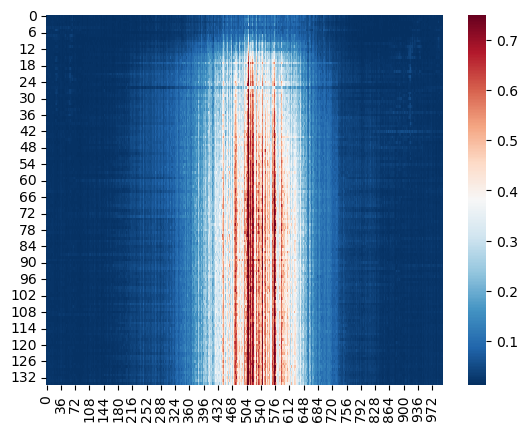

In [121]:
sns.heatmap(tfbs, cmap='RdBu_r', vmax=0.75)